# Raster processing with XArray

http://xarray.pydata.org

Robin Wilson &nbsp; &nbsp; &nbsp; @sciremotesense &nbsp; &nbsp; &nbsp; robin@rtwilson.com

https://github.com/robintw/RastersRevealedTalk

## Problem

Processing large time series of raster data is **difficult**

**Example**:

We have many decades of daily raster data, and want to get:

- Seasonal means and standard deviations

- Long time-series across specific points

- Individual images at specific times

# HOW?

## `XArray`

The power of `pandas` for multidimension arrays

- Labelled

- Multidimensional

- Efficient

- Easy to use!

## Related tools / Prerequisites?

- `python` (obviously!)
- `numpy`
- `pandas`
- `matplotlib`
- `GDAL`
- `rasterio`

## Previous experience?

**Q:** How many people are experienced with `numpy`?

**Q:** ...with `pandas`?

**Q:** ...with `GDAL`?

In [1]:
import datetime

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import xarray as xr

## Example

In [3]:
PM25 = xr.open_dataarray('/Users/robin/code/MAIACProcessing/All2014.nc')

In [4]:
PM25.shape

(181, 1162, 1240)

In [5]:
PM25.dims

(u'time', u'y', u'x')

In [6]:
seasonal = PM25.groupby('time.season').mean(dim='time')

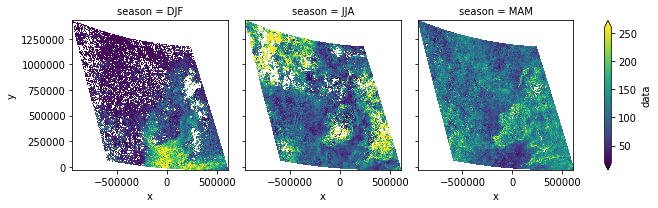

In [7]:
seasonal.plot.imshow(col='season', robust=True)

In [8]:
time_series = PM25.isel(x=1000, y=1100).to_pandas().dropna()

In [9]:
time_series

time
2014-01-07     62.0
2014-01-17    121.0
2014-01-25    127.0
2014-02-10    135.0
2014-02-11    186.0
2014-02-18    237.0
2014-02-25    352.0
2014-02-26    293.0
2014-02-27    260.0
2014-03-01    165.0
2014-03-08    221.0
2014-03-09    221.0
2014-03-10    291.0
2014-03-13    552.0
2014-03-16    156.0
2014-03-21    159.0
2014-03-22    160.0
2014-03-23    163.0
2014-03-25    261.0
2014-03-30    362.0
2014-04-04     19.0
2014-04-09     19.0
2014-04-10     19.0
2014-04-11     19.0
2014-04-13     33.0
2014-04-14     19.0
2014-04-16    159.0
2014-04-18     53.0
2014-04-19    118.0
2014-04-24    194.0
2014-04-25    250.0
2014-05-10    154.0
2014-05-13    181.0
2014-05-14     19.0
2014-05-15    117.0
2014-05-17    239.0
2014-05-22    188.0
2014-06-02    189.0
2014-06-05     71.0
2014-06-07    107.0
2014-06-13    115.0
2014-06-14    324.0
2014-06-15     64.0
2014-06-18    132.0
2014-06-20    101.0
2014-06-21    115.0
2014-06-23    200.0
2014-06-27    162.0
dtype: float32

In [10]:
one_day = PM25.sel(time='2014-02-20')

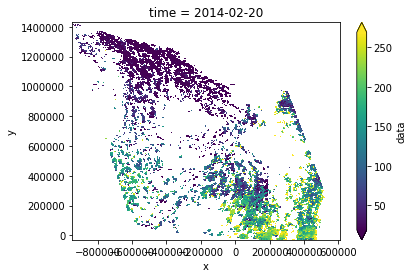

In [11]:
one_day.plot(robust=True)

## Summary

In [12]:
seasonal = PM25.groupby('time.season').mean(dim='time')

In [13]:
time_series = PM25.isel(x=1000, y=1100).to_pandas().dropna()

In [14]:
one_day = PM25.sel(time='2014-02-20')

## Plan

- Introduction to XArray

- Efficient processing with `dask` and `dask.distributed`

- Getting raster data into and out of XArray

- Geographic processing

- Where next...?

## Introduction to XArray

`xarray.DataArray` is a fancy, labelled version of a `numpy.ndarray`

`xarray.Dataset` is a collection of multiple `DataArray`s which share dimensions

In [15]:
arr = np.random.rand(3, 4, 2)

In [16]:
xr.DataArray(arr)

<xarray.DataArray (dim_0: 3, dim_1: 4, dim_2: 2)>
array([[[ 0.291147,  0.311481],
        [ 0.242399,  0.50576 ],
        [ 0.0414  ,  0.70285 ],
        [ 0.970111,  0.366626]],

       [[ 0.673288,  0.692703],
        [ 0.711139,  0.292571],
        [ 0.767792,  0.30895 ],
        [ 0.747633,  0.903716]],

       [[ 0.342803,  0.00336 ],
        [ 0.755828,  0.851831],
        [ 0.286764,  0.02013 ],
        [ 0.273488,  0.938408]]])
Dimensions without coordinates: dim_0, dim_1, dim_2

In [17]:
xr.DataArray(arr, dims=('x', 'y', 'time'))

<xarray.DataArray (x: 3, y: 4, time: 2)>
array([[[ 0.291147,  0.311481],
        [ 0.242399,  0.50576 ],
        [ 0.0414  ,  0.70285 ],
        [ 0.970111,  0.366626]],

       [[ 0.673288,  0.692703],
        [ 0.711139,  0.292571],
        [ 0.767792,  0.30895 ],
        [ 0.747633,  0.903716]],

       [[ 0.342803,  0.00336 ],
        [ 0.755828,  0.851831],
        [ 0.286764,  0.02013 ],
        [ 0.273488,  0.938408]]])
Dimensions without coordinates: x, y, time

In [18]:
da = xr.DataArray(arr,
                  dims=('x', 'y', 'time'),
                  coords={'x': [10, 20, 30],
                          'y': [0.3, 0.7, 1.3, 1.5],
                          'time': [datetime.datetime(2016, 3, 5),
                                   datetime.datetime(2016, 4, 7)]})

In [19]:
da

<xarray.DataArray (x: 3, y: 4, time: 2)>
array([[[ 0.291147,  0.311481],
        [ 0.242399,  0.50576 ],
        [ 0.0414  ,  0.70285 ],
        [ 0.970111,  0.366626]],

       [[ 0.673288,  0.692703],
        [ 0.711139,  0.292571],
        [ 0.767792,  0.30895 ],
        [ 0.747633,  0.903716]],

       [[ 0.342803,  0.00336 ],
        [ 0.755828,  0.851831],
        [ 0.286764,  0.02013 ],
        [ 0.273488,  0.938408]]])
Coordinates:
  * y        (y) float64 0.3 0.7 1.3 1.5
  * x        (x) int64 10 20 30
  * time     (time) datetime64[ns] 2016-03-05 2016-04-07

In [20]:
da.sel(time='2016-03-05')

<xarray.DataArray (x: 3, y: 4)>
array([[ 0.291147,  0.242399,  0.0414  ,  0.970111],
       [ 0.673288,  0.711139,  0.767792,  0.747633],
       [ 0.342803,  0.755828,  0.286764,  0.273488]])
Coordinates:
  * y        (y) float64 0.3 0.7 1.3 1.5
  * x        (x) int64 10 20 30
    time     datetime64[ns] 2016-03-05

In [21]:
da.isel(time=1)

<xarray.DataArray (x: 3, y: 4)>
array([[ 0.311481,  0.50576 ,  0.70285 ,  0.366626],
       [ 0.692703,  0.292571,  0.30895 ,  0.903716],
       [ 0.00336 ,  0.851831,  0.02013 ,  0.938408]])
Coordinates:
  * y        (y) float64 0.3 0.7 1.3 1.5
  * x        (x) int64 10 20 30
    time     datetime64[ns] 2016-04-07

In [22]:
da.sel(x=slice(0, 20))

<xarray.DataArray (x: 2, y: 4, time: 2)>
array([[[ 0.291147,  0.311481],
        [ 0.242399,  0.50576 ],
        [ 0.0414  ,  0.70285 ],
        [ 0.970111,  0.366626]],

       [[ 0.673288,  0.692703],
        [ 0.711139,  0.292571],
        [ 0.767792,  0.30895 ],
        [ 0.747633,  0.903716]]])
Coordinates:
  * y        (y) float64 0.3 0.7 1.3 1.5
  * x        (x) int64 10 20
  * time     (time) datetime64[ns] 2016-03-05 2016-04-07

In [23]:
da.mean(dim='time')

<xarray.DataArray (x: 3, y: 4)>
array([[ 0.301314,  0.37408 ,  0.372125,  0.668368],
       [ 0.682996,  0.501855,  0.538371,  0.825675],
       [ 0.173082,  0.803829,  0.153447,  0.605948]])
Coordinates:
  * y        (y) float64 0.3 0.7 1.3 1.5
  * x        (x) int64 10 20 30

In [24]:
da.mean(dim=['x', 'y'])

<xarray.DataArray (time: 2)>
array([ 0.508649,  0.491532])
Coordinates:
  * time     (time) datetime64[ns] 2016-03-05 2016-04-07

In [25]:
PM25.sel(time='2014').groupby('time.month').std(dim='time')

<xarray.DataArray u'data' (month: 6, y: 1162, x: 1240)>
array([[[        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan],
        ..., 
        [        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan]],

       [[        nan,         nan, ...,         nan,         nan],
        [   0.      ,         nan, ...,         nan,         nan],
        ..., 
        [        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan]],

       ..., 
       [[  23.976839,    0.      , ...,         nan,         nan],
        [   1.      ,    2.5     , ...,         nan,         nan],
        ..., 
        [        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan]],

       [[ 146.487762,  125.048988, ...,         nan,         nan],
        [ 14

## Efficient processing with `dask` and `dask.distributed`

`dask` creates a *computational graph* of your processing steps, and then executes it *as efficiently as possible*.

This includes *only loading data that is actually needed* and *only processing things once*.

In [26]:
data = xr.open_mfdataset(['DaskTest1.nc', 'DaskTest2.nc'], chunks={'time':10})['data']
avg = data.mean(dim='time')

[Dask execution graph](ExampleGraph_1.png)

In [27]:
seasonal = data.groupby('time.season').mean(dim='time')

[Dask execution graph](ExampleGraph_2.png)

## `dask.distributed`

All of these different *chunks*, and separate processing chains can be run on **separate computers**.

- [Dask Distributed Example](Dask Distributed Example.ipynb)
- [Live Dashboard](http://localhost:8787)

## Getting raster data into `xarray`

`xarray` can read various raster formats directly:

- NetCDF
- HDF
- GRIB

However, `xarray` can't _currently_ read other standard raster formats like:

- GeoTIFF
- Erdas IMAGINE
- Arc Grids
- ENVI format
- etc...

## `rasterio`

A nice, Pythonic interface to `GDAL` - making it really easy to read almost any raster file into Python

In [28]:
import rasterio

with rasterio.open('SPOT_ROI.tif') as src:
    data = src.read(1)
    
print(data)

[[51 51 51 ..., 32 32 29]
 [51 51 51 ..., 29 30 27]
 [54 54 52 ..., 30 29 28]
 ..., 
 [33 34 34 ..., 31 35 35]
 [34 34 34 ..., 32 34 34]
 [34 34 34 ..., 31 33 38]]


## Joining them up
All we need to do is write some functions to read from `rasterio` and create a `DataArray`

But it's a bit more difficult than that...

- Need to deal with geographic metadata
- Geographic co-ordinates
- Dimension names

In [29]:
from rasterio_to_xarray import rasterio_to_xarray, xarray_to_rasterio, xarray_to_rasterio_by_band

In [30]:
data = rasterio_to_xarray('SPOT_ROI.tif')
data

rasterio_to_xarray.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  data = np.where(data == src.nodata, np.nan, data)


<xarray.DataArray (y: 1644, x: 1435)>
array([[ 51.,  51.,  51., ...,  32.,  32.,  29.],
       [ 51.,  51.,  51., ...,  29.,  30.,  27.],
       [ 54.,  54.,  52., ...,  30.,  29.,  28.],
       ..., 
       [ 33.,  34.,  34., ...,  31.,  35.,  35.],
       [ 34.,  34.,  34., ...,  32.,  34.,  34.],
       [ 34.,  34.,  34., ...,  31.,  33.,  38.]])
Coordinates:
  * y        (y) float64 1.484e+05 1.484e+05 1.484e+05 1.484e+05 1.484e+05 ...
  * x        (x) float64 4.301e+05 4.301e+05 4.302e+05 4.302e+05 4.302e+05 ...
Attributes:
    crs: +ellps=airy +k=0.999601 +lat_0=49 +lon_0=-2 +no_defs +proj=tmerc +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +x_0=400000 +y_0=-100000
    affine: (430130.2396, 10.0, 0.0, 148415.8755, 0.0, -10.0)

## Example - combining multiple files into a time-series

Take a large number of files, one from each orbit of a satellite, and put them into one large array with a time dimension.

In [31]:
import os
from glob import glob


In [32]:
def maiac_file_to_da(filename):
    da = rasterio_to_xarray(filename)
    
    time_str = os.path.basename(filename)[17:-17]
    time_obj = datetime.datetime.strptime(time_str, '%Y%j%H%M')
    da.coords['time'] = time_obj
    
    return da

In [33]:
files = glob('MAIAC_files/*.tif')

In [34]:
list_of_data_arrays = [maiac_file_to_da(filename) for filename in files]

In [35]:
combined = xr.concat(list_of_data_arrays, dim='time')

In [36]:
combined

<xarray.DataArray (time: 10, y: 1162, x: 1240)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ..., 
       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]], dtype=float32)
Coordinates:
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * time     (time) datetime64[ns] 2003-04-16T14:40:00 2002-03-19T11:20

## Getting raster data out of xarray

In [37]:
mean = combined.mean(dim='time', keep_attrs=True)

In [38]:
xarray_to_rasterio(mean, 'Mean.tif')

In [39]:
daily = combined.groupby('time.day').mean(dim='time', keep_attrs=True)

In [40]:
xarray_to_rasterio_by_band(daily, 'Daily_', dim='day')

Exported 16
Exported 19
Exported 28
Exported 29


In [41]:
!ls Daily_*.tif

Daily_16.tif Daily_19.tif Daily_28.tif Daily_29.tif


## Geographic processing

Can `xarray` do standard _geographic_ processing methods?

- Zonal statistics
- Reprojecting
- etc...

- A `DataArray` is just a fancy `numpy` array

- Many things will work directly, otherwise just use `.values` to get the `numpy` array

## Zonal statistics

`rasterstats` is a Python module for doing zonal statistics

We can use the same approach as the Python module, but modified to work with `DataArray` objects

## Zonal statistics

1. Load shapefile
2. For each feature in the shapefile:
    - Rasterize the feature into an array
    - Use this array to index the DataArray
    - Do whatever processing you want (`mean`, `median`, `std` etc)

(There are more efficient ways to do this if no polygons overlap)

## And more...

- Apply functions across axes (eg. linear regression over time, separately for each pixel)

- Rolling windows over any axis

- Automatic broadcasting and alignment

- Hierarchical indexes

- OPeNDAP

## Where next...?

- `xarray` is under rapid development
- General approach is stable, some details may change
- Very responsive developers

- Raster I/O will be built-in to `xarray` soon-ish

- `dask` is rapidly improving too

## Resources

- These slides and notebooks are available online at https://github.com/robintw/RastersRevealedTalk